# This code allows to load precipitation data and temperature data from which we build a dataframe with precipitation data and PET at the hourly resolution

# START by dowloading the file 'data.zip' using the link below and extract it. Save the resulting data folder in the folder 'experiments'.

https://www.dropbox.com/scl/fi/mo4xg95ktj7yt09e1o78a/data.zip?rlkey=9m8e4nshv831g7q129c1vsy53&st=e7xmas3s&dl=0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
sys.path.append('../../../')
os.chdir('../../data/simulated_data/')
import pyeto

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return (date.timestamp())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

site = 'LUG'

site2name = {'LUG':'Lugano', 'PUY':'Pully', 'BAS':'Basel'}
ls_latitude = {'LUG': 46, 'SIO': 46.13, 'PUY': 46.31, 'BAS':47.32}

# 1. Loading precipitation data

In [3]:
df = pd.read_csv('./precipitation/order_122969_{0}_rre150h0_1_data.txt'.format(site), sep=';')
df['datetime'] = df['time'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d%H'))
df['t'] = df['datetime'].apply(lambda x: toYearFraction(x))

/tmp/ipykernel_49300/376841677.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./precipitation/order_122969_{0}_rre150h0_1_data.txt'.format(site), sep=';')


In [4]:
df = df.replace('-', np.NaN)
df = df.rename(columns={"rre150h0": "p"})
df['p'] = df['p'].astype(float)

#### Checking that there is no data gap

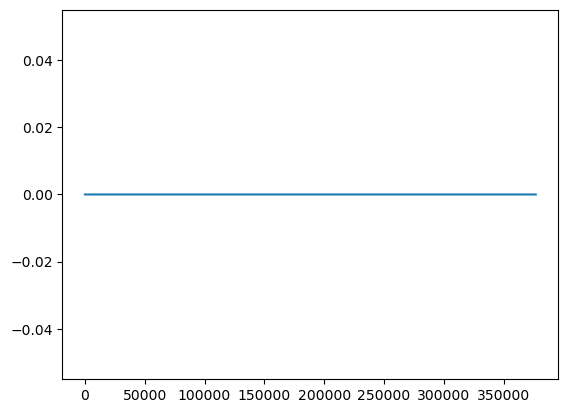

In [5]:
diffhour = (df['datetime'].sort_values().diff() > pd.to_timedelta('1 hour')).to_numpy()
idxs = np.where(diffhour>0.5)[0]
plt.plot(diffhour)

# 2. Loading temperature data that will be used to compute PET

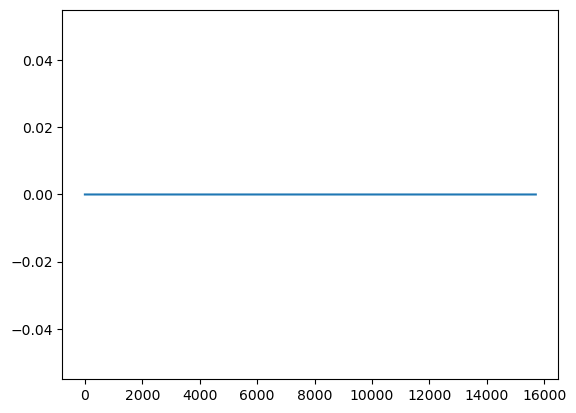

In [6]:
Tmax = pd.read_csv('./daily_temperature_min_max/order_123003_{0}_tre200dx_1_data.txt'.format(site), header=0, sep=';', engine='python')
Tmax['datetime'] = Tmax['time'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
Tmax['t'] = Tmax['datetime'].apply(lambda x: toYearFraction(x))
Tmax = Tmax.rename(columns={"tre200dx": "tmax"})
Tmax = Tmax.replace('-', np.NaN)

Tmin = pd.read_csv('./daily_temperature_min_max/order_123003_{0}_tre200dn_1_data.txt'.format(site), header=0, sep=';',  engine='python')
Tmin['datetime'] = Tmin['time'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
Tmin['t'] = Tmin['datetime'].apply(lambda x: toYearFraction(x))
Tmin = Tmin.rename(columns={"tre200dn": "tmin"})
Tmin = Tmin.replace('-', np.NaN)

Tmean = pd.read_csv('./daily_temperature_mean/order_122970_{0}_tre200d0_1_data.txt'.format(site), header=0, sep=';',  engine='python')
Tmean['datetime'] = Tmean['time'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
Tmean['t'] = Tmean['datetime'].apply(lambda x: toYearFraction(x))
Tmean = Tmean.rename(columns={"tre200d0": "tabs"})
Tmean = Tmean.replace('-', np.NaN)

data = Tmin
#data = pd.merge(data, Tmin, on="datetime", how="inner")
data = pd.merge(data, Tmax, on="datetime", how="inner")
data = pd.merge(data, Tmean, on="datetime", how="inner")

diffhour = (data['datetime'].sort_values().diff() > pd.to_timedelta('1 day')).to_numpy()
idxs = np.where(diffhour>0.5)[0]
plt.plot(diffhour)

# 3. Computing PET (daily)

In [7]:
# PET
def get_PET_hargreaves(tmin,tmean,tmax,Date,latitude):
    lat = pyeto.deg2rad(float(latitude))  # Convert latitude to radians
    day_of_year = Date.timetuple().tm_yday
    sol_dec = pyeto.sol_dec(day_of_year)            # Solar declination
    sha = pyeto.sunset_hour_angle(lat, sol_dec)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    et_rad = pyeto.et_rad(lat, sol_dec, sha, ird)   # Extraterrestrial radiation
    tmax = max(tmax,tmin)
    tmin = min(tmin,tmax)
    tmean = max(min(tmean,tmax),tmin)
    return pyeto.hargreaves(tmin, tmax, tmean, et_rad)

lst = np.arange(0,len(data),1)
PET = np.array(list(map(lambda t: get_PET_hargreaves(data.iloc[t]['tmin'], data.iloc[t]['tabs'], data.iloc[t]['tmax'], data['datetime'][t], ls_latitude[site]), lst) ))
data['pet'] = PET

# 4. Keeping only dates for which we have both precipitation and PET computed

In [8]:
df = df.sort_values(by='datetime', axis=0)
data = data.sort_values(by='datetime', axis=0)
begindate = max(df.iloc[0]['datetime'], data.iloc[0]['datetime'])
enddate = min(df.iloc[-1]['datetime'], data.iloc[-1]['datetime'])
enddate = enddate-pd.to_timedelta('1 hour')
print(begindate, enddate)
df = df.loc[df['datetime'].apply(lambda x: (begindate<=x) and (enddate>=x))]
data = data.loc[data['datetime'].apply(lambda x: (begindate<=x) and (enddate>=x))]

1981-01-01 00:00:00 2023-12-30 23:00:00


In [9]:
df

,stn,time,p,datetime,t
1,LUG,1981010100,0.0,1981-01-01 00:00:00,1981.000114
2,LUG,1981010101,0.0,1981-01-01 01:00:00,1981.000228
3,LUG,1981010102,0.0,1981-01-01 02:00:00,1981.000342
4,LUG,1981010103,0.0,1981-01-01 03:00:00,1981.000457
5,LUG,1981010104,0.0,1981-01-01 04:00:00,1981.000571
...,...,...,...,...,...
376892,LUG,2023123019,0.0,2023-12-30 19:00:00,2023.996804
376893,LUG,2023123020,0.0,2023-12-30 20:00:00,2023.996918
376894,LUG,2023123021,0.0,2023-12-30 21:00:00,2023.997032
376895,LUG,2023123022,0.0,2023-12-30 22:00:00,2023.997146


In [10]:
data

,stn_x,time_x,tmin,datetime,t_x,stn_y,time_y,tmax,t_y,stn,time,tabs,t,pet
0,LUG,19810101,0.3,1981-01-01,1981.000114,LUG,19810101,16.0,1981.000114,LUG,19810101,8.0,1981.000114,0.972782
1,LUG,19810102,3.3,1981-01-02,1981.002854,LUG,19810102,12.7,1981.002854,LUG,19810102,8.4,1981.002854,0.768530
2,LUG,19810103,0.6,1981-01-03,1981.005594,LUG,19810103,7.3,1981.005594,LUG,19810103,3.6,1981.005594,0.533057
3,LUG,19810104,3.5,1981-01-04,1981.008333,LUG,19810104,13.3,1981.008333,LUG,19810104,8.2,1981.008333,0.788154
4,LUG,19810105,2.1,1981-01-05,1981.011073,LUG,19810105,7.7,1981.011073,LUG,19810105,5.0,1981.011073,0.525928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15699,LUG,20231226,4.7,2023-12-26,2023.983676,LUG,20231226,10.4,2023.983676,LUG,20231226,7.9,2023.983676,0.570308
15700,LUG,20231227,4.1,2023-12-27,2023.986416,LUG,20231227,11.3,2023.986416,LUG,20231227,7.3,2023.986416,0.627777
15701,LUG,20231228,6.8,2023-12-28,2023.989155,LUG,20231228,9.1,2023.989155,LUG,20231228,8.1,2023.989155,0.367323
15702,LUG,20231229,7.7,2023-12-29,2023.991895,LUG,20231229,9.2,2023.991895,LUG,20231229,8.4,2023.991895,0.301190


# 5. Adding PET to the final DataFrame and saving the file

In [11]:
# convert daily PET to hourly data
df_index = data[['datetime','pet']].set_index('datetime')
hours2daily = df['datetime'].apply(lambda x: df_index.loc[x.strftime('%Y-%m-%d')].values[0])
#hours2hourlypet = [data.loc[data['datetime']==day]['pet'].values[0]/24 for day in hours2days]
df['pet'] = hours2daily/24

In [12]:
df.fillna(0, inplace=True)
df['p'].isnull().sum()

0

In [13]:
if not os.path.exists('hourly_data_withPET'):
    os.makedirs('hourly_data_withPET')
df.to_csv('./hourly_data_withPET/{0}.csv'.format(site2name[site]), index=False)